In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep

hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)

In [21]:
# This block is the same as 1_dataset.ipynb

dataset = "/eos/home-g/gkrzmanc/dataset_1408_CLIC_more_particles_DS.root"
#dataset = "/eos/user/g/gkrzmanc/ClicDet_v1_25_07_2023_full.root"
pref = "/eos/user/m/mgarciam/datasets_mlpf/120823_condor_spread_5_6/pf_tree_{}.root"

datasets = [pref.format(i) for i in range(1, 11)]
class Args:
    def __init__(self):
        self.data_train = datasets
        self.data_val = datasets
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_data/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train')

In [22]:
iterator = iter(train_data)
g, gt = next(iterator)
g
g.ndata['particle_number'].unique()
gt
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)


=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


In [39]:
g, y = next(iterator)
y.shape
y

tensor([[-4.2818e-01, -2.4761e-01, -8.6911e-01,  4.8554e+01,  4.8545e+01,
          9.3965e-01,  2.1120e+03],
        [-6.0929e-01, -2.6530e-01, -7.4725e-01,  6.6703e-01,  6.6703e-01,
          1.9023e-04, -2.1100e+02],
        [ 1.0340e-01,  2.0449e-01,  9.7339e-01,  2.0502e+00,  2.0454e+00,
          1.3957e-01,  2.1100e+02],
        [ 9.0562e-01,  3.9935e-01,  1.4275e-01,  8.1078e+00,  8.0531e+00,
          9.3956e-01,  2.1120e+03],
        [ 3.1426e-02, -8.5100e-02,  9.9588e-01,  2.8383e+01,  2.8379e+01,
          4.9762e-01,  1.3000e+02]])

In [40]:
ht = g.ndata["hit_type"]
ht[ht[:, 2]==1]

tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0]])

In [41]:
#print(g.ndata["e_hits"].flatten())
#print(g.ndata["h"][:, 7])
hit_energies = g.ndata["e_hits"].flatten()
part_idx = g.ndata["particle_number"]
energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)[1:]
y_energy = y[:, 3]
print(y_energy)

tensor([48.5544,  0.6670,  2.0502,  8.1078, 28.3831])


In [42]:
fracs1 = energy_from_showers/y_energy
print(fracs1)

tensor([1.1388, 0.3445, 0.6952, 0.7829, 1.0504])


In [43]:
low_frac_particles = np.where(fracs1 < 0.05)[0] + 1
print(low_frac_particles)
low_frac_part_idx = []
for i in range(len(part_idx)):
    #print(part_idx[i])
    if part_idx[i].item() in low_frac_particles:
        low_frac_part_idx.append(i)
print(low_frac_part_idx)

[]
[]


In [44]:
y_energy
type(part_idx)
print(low_frac_part_idx)

[]


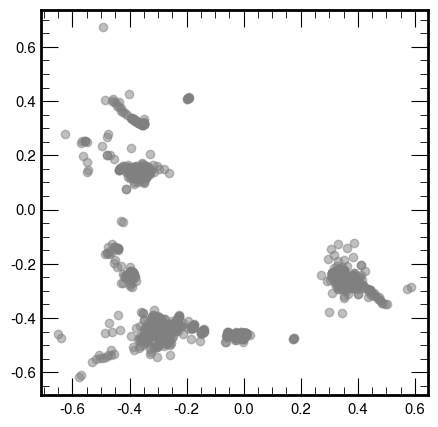

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(g.ndata["h"][:, 0], g.ndata["h"][:, 1], alpha=0.5, color="gray")
ax.scatter(g.ndata["h"][low_frac_part_idx, 0], g.ndata["h"][low_frac_part_idx, 1], alpha=0.5, c=part_idx[low_frac_part_idx].tolist())
fig.show()



In [30]:
g.ndata["h"][part_idx == 4]

tensor([[-0.1966,  0.4110, -0.3323,  ...,  0.0000,  0.0389,  0.0000],
        [-0.1958,  0.4097, -0.3308,  ...,  0.0000,  0.0061,  0.0000],
        [-0.1966,  0.4110, -0.3308,  ...,  0.0000,  0.0265,  0.0000],
        ...,
        [-0.3973,  0.1531, -0.7688,  ...,  1.0000,  0.0298,  0.0000],
        [-0.3933,  0.1334, -0.7767,  ...,  1.0000,  0.0171,  0.0000],
        [-0.4060,  0.1554, -0.7688,  ...,  1.0000,  0.1569,  0.0000]])

In [31]:
y_energy

tensor([39.6297,  1.9953, 37.7425, 18.2750])

In [32]:
y_pid = y[:, -1].to(torch.long)
y_pid

tensor([ 2112,   130,   130, -2212])

In [33]:
from torch_scatter import scatter_sum
def get_ratios(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_types = g.ndata["hit_type"][true_idx]
    hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
    track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
    hit_energies = g.ndata["e_hits"].flatten()#[true_idx]  #[hit_idx]
    where_e_zero = hit_energies == 0
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
    y_energy = y[:, 3]
    y_pid = y[:, -1].to(torch.long)
    energy_from_showers = energy_from_showers[1:]
    assert len(energy_from_showers) > 0
    if return_pid_dict:
        pids = y_pid.unique().long()
        pid_dict = {int(pid): (energy_from_showers[y_pid == pid] / y_energy[y_pid == pid]).tolist() for pid in pids}
        pid_dict["ALL"] = (energy_from_showers / y_energy).tolist()
        return pid_dict
    return (energy_from_showers / y_energy).tolist()


In [34]:
all_ratios = {}
num_particles = []

def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

for i in tqdm(range(100)):
    g, y = next(iterator)
    num_part = y.shape[0]
    num_particles.append(num_part)
    ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
    all_ratios = upd_dict(all_ratios, ratios)
    #TODOs tmrw: check particle number dist., how many are we throwing away



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.34it/s]


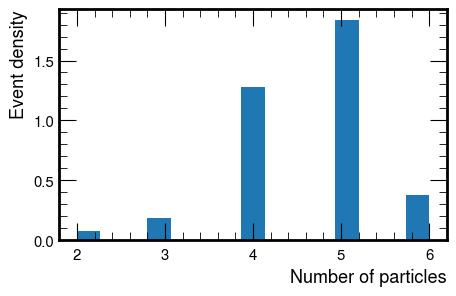

In [35]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("Number of particles")
ax.hist(num_particles, bins=15, density=True)
ax.set_ylabel("Event density")
fig.show()


In [36]:
for key in all_ratios:
    print(key, len([x for x in all_ratios[key] if x <= 0.05])/len(all_ratios[key]))

-2212 0.0
-211 0.0
211 0.027777777777777776
2112 0.05982905982905983
ALL 0.02391304347826087
130 0.017857142857142856
2212 0.0


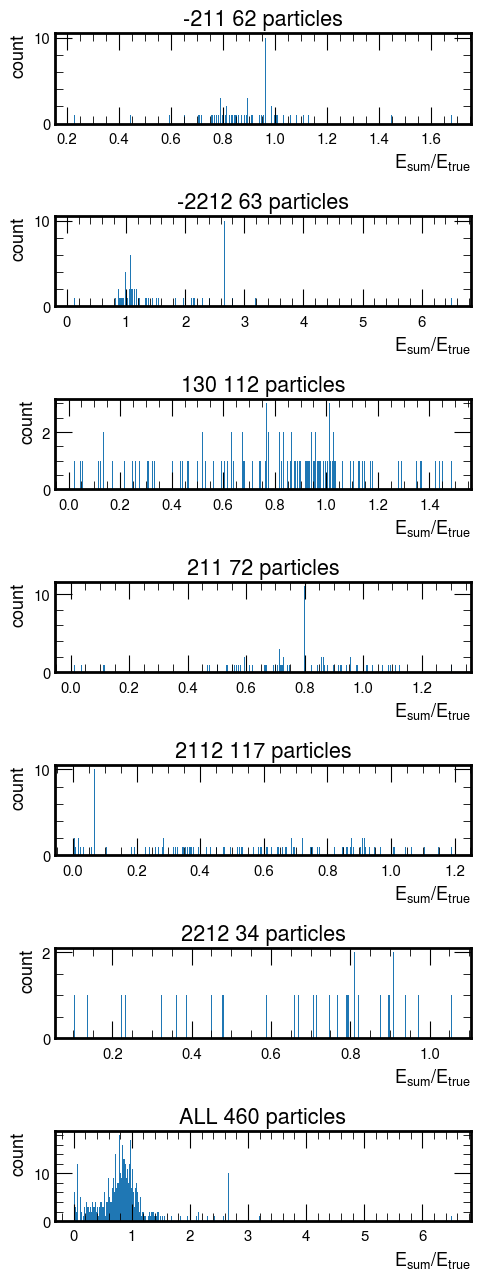

In [37]:
import matplotlib.pyplot as plt
all_ratios = {str(k): v for k, v in all_ratios.items()}
keys = sorted(list(all_ratios.keys()))
fig, ax = plt.subplots(len(keys), figsize=(5, 13))

for i in range(len(keys)):
    ax[i].hist(all_ratios[keys[i]], bins=400)
    #ax[i].set_xlim(-0.5, 2)
    ax[i].set_ylabel("count")
    ax[i].set_xlabel(r"$E_{sum}/E_{true}$")
    ax[i].set_title(f"{keys[i]} {len(all_ratios[keys[i]])} particles")

fig.tight_layout()

#fig.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/new_dataset/energy_hist_corr1.pdf")
fig.show()

In [38]:
#import pickle
#pickle.dump(all_ratios, open("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/corr_ds/PID_filtered_energy_sum_vs_true.pkl", "wb"))